In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32') # default is set to float64

# Import all the necessary packages

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Create the base pre-trained model

In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer

In [4]:
x = base_model.output
x = GlobalAveragePooling2D()(x)


# Let's add a fully-connected layer

In [5]:
x = Dense(1024, activation='relu')(x)

# And a logistic layer -- we have 4 classes

In [6]:
predictions = Dense(4, activation='softmax')(x)

# This is the model we will train

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers

In [25]:
for layer in base_model.layers:
    layer.trainable = True


# Compile the model (should be done *after* setting layers to non-trainable)

In [26]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Read training csv file

In [33]:
import os
import numpy as np
import pandas as pd

PATH="C:/Users/manoj/PycharmProjects/data/PlantPathology2020"

train_dir = os.path.join(PATH, '150X200')
train_dir = os.path.join(PATH, 'images')
validation_dir = os.path.join(PATH, '150X200')
validation_dir = os.path.join(PATH, 'images')

df=pd.read_csv(PATH+'/train.csv')


# Set image size

In [34]:


np.random.seed(25)

batch_size = 128
epochs = 15
IMG_HEIGHT = 133
#IMG_HEIGHT = 224
IMG_WIDTH = 200
#IMG_WIDTH = 224

# Make training dataframe ready for model

In [35]:
dfArr=np.asarray(df[["healthy","multiple_diseases","rust","scab"]])
options = { 0:"healthy"
           ,1:"multiple_diseases"
           ,2:"rust"
           ,3:"scab"
}
df["label"]=[options[np.argmax(arr)] for arr in dfArr]
df["name"] = df["image_id"]+'.jpg'
#testImagesDf
#train_df = trainImagesDf[["image_id","label"]]
df = df[["name","label"]]
df.rename(columns={"name":"filename","label":"class"}, inplace=True)


# Make training and validation data set from the original training dataframe

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["class"]), df.drop(columns=["filename"]), test_size=0.2)
train_df=X_train
train_df["class"]=y_train
validation_df=X_test
validation_df["class"]=y_test
#validation_df

# Some variables for the epoch

In [37]:
total_train = len(train_df)
total_val   = len(validation_df)

# Create Image Data Generators

In [88]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data


In [89]:
#= validation_image_generator 
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

# Generate train Images

In [91]:
train_data_gen = train_image_generator.flow_from_dataframe( batch_size=batch_size,
                                                            dataframe=train_df,
                                                            directory=train_dir,
                                                            x_col="filename",
                                                            y_col="class",
                                                            target_size=(IMG_HEIGHT, IMG_WIDTH) #, class_mode='binary'
                                                          )

Found 1456 validated image filenames belonging to 4 classes.


# Generate validation Images

In [92]:
val_data_gen = validation_image_generator.flow_from_dataframe( batch_size=batch_size,
                                                            dataframe=validation_df,
                                                            directory=validation_dir,
                                                            x_col="filename",
                                                            y_col="class",
                                                            target_size=(IMG_HEIGHT, IMG_WIDTH) #, class_mode='binary'
                                                          )

Found 365 validated image filenames belonging to 4 classes.


# Train the model on the new data for a few epochs

In [93]:
history=model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    #epochs=epochs,
    epochs=3,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 2 steps
Epoch 1/3
11/11 [==============================] - 43s 4s/step - loss: 0.0579 - accuracy: 0.9812 - val_loss: 0.2414 - val_accuracy: 0.9336
Epoch 2/3
11/11 [==============================] - 39s 4s/step - loss: 0.0588 - accuracy: 0.9789 - val_loss: 0.2400 - val_accuracy: 0.9336
Epoch 3/3
11/11 [==============================] - 39s 4s/step - loss: 0.0777 - accuracy: 0.9721 - val_loss: 0.2372 - val_accuracy: 0.9336


# At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. 

# We will freeze the bottom N layers and train the remaining top layers.

# Let's visualize layer names and layer indices to see how many layers

# We should freeze:

In [21]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

# We chose to train the top 2 inception blocks, i.e. we will freeze the first 249 layers and unfreeze the rest:

In [85]:

for layer in model.layers[:249]:
   layer.trainable = True
for layer in model.layers[249:]:
   layer.trainable = False

# We need to recompile the model for these modifications to take effect
# Let's use SGD with a low learning rate

In [86]:

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


# We train our model again (this time fine-tuning the top 2 inception blocks alongside the top Dense layers

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 2 steps
Epoch 1/100
11/11 [==============================] - 44s 4s/step - loss: 0.0668 - accuracy: 0.9759 - val_loss: 0.2292 - val_accuracy: 0.9375
Epoch 2/100
11/11 [==============================] - 39s 4s/step - loss: 0.0855 - accuracy: 0.9729 - val_loss: 0.1940 - val_accuracy: 0.9570
Epoch 3/100
11/11 [==============================] - 41s 4s/step - loss: 0.0961 - accuracy: 0.9695 - val_loss: 0.2394 - val_accuracy: 0.9492
Epoch 4/100
11/11 [==============================] - 39s 4s/step - loss: 0.0908 - accuracy: 0.9684 - val_loss: 0.2333 - val_accuracy: 0.9492
Epoch 5/100
11/11 [==============================] - 39s 4s/step - loss: 0.0766 - accuracy: 0.9744 - val_loss: 0.1937 - val_accuracy: 0.9609
Epoch 6/100
11/11 [==============================] - 39s 4s/step - loss: 0.0517 - accuracy: 0.9857 - val_loss: 0.1597 - val_accuracy: 0.9648
Epoch 7/100
11/11 [==============================] - 39s 4s/ste

11/11 [==============================] - 39s 4s/step - loss: 0.0667 - accuracy: 0.9804 - val_loss: 0.2387 - val_accuracy: 0.9414
Epoch 58/100
11/11 [==============================] - 39s 4s/step - loss: 0.0708 - accuracy: 0.9797 - val_loss: 0.1409 - val_accuracy: 0.9688
Epoch 59/100
11/11 [==============================] - 39s 4s/step - loss: 0.0782 - accuracy: 0.9767 - val_loss: 0.1698 - val_accuracy: 0.9531
Epoch 60/100
11/11 [==============================] - 39s 4s/step - loss: 0.0807 - accuracy: 0.9752 - val_loss: 0.1298 - val_accuracy: 0.9688
Epoch 61/100
11/11 [==============================] - 39s 4s/step - loss: 0.0902 - accuracy: 0.9767 - val_loss: 0.2028 - val_accuracy: 0.9414
Epoch 62/100
11/11 [==============================] - 39s 4s/step - loss: 0.0816 - accuracy: 0.9752 - val_loss: 0.2010 - val_accuracy: 0.9375
Epoch 63/100
11/11 [==============================] - 39s 4s/step - loss: 0.0703 - accuracy: 0.9797 - val_loss: 0.1170 - val_accuracy: 0.9688
Epoch 64/100
11/11 

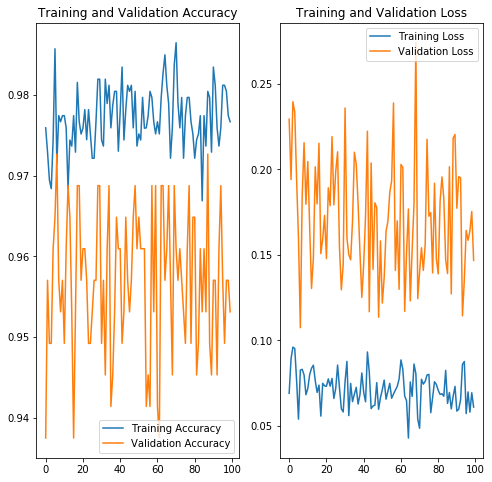

In [87]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
#    epochs=epochs,
    epochs=100,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

plotHistory(history,100)

# Create the base pre-trained model

# Create the base pre-trained model

# Create the base pre-trained model

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

In [52]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [82]:
def plotHistory(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

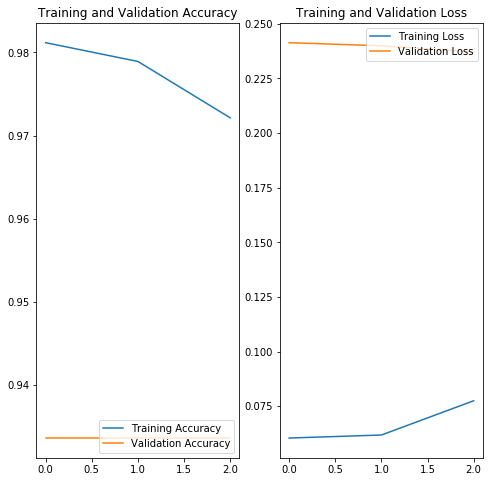

In [95]:
history.history.keys()
plotHistory(history,3)

In [50]:
for i in history.history:
    print(i)

loss
val_loss


In [101]:
test_df=pd.read_csv(PATH+'/test.csv')
test_df.rename(columns={"image_id":"filename"}, inplace=True)
test_df["filename"]=test_df["filename"]+".jpg"
#test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our testing data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our testing data

test_data_gen = test_image_generator.flow_from_dataframe( batch_size=batch_size,
                                                            dataframe=test_df,
                                                            directory=train_dir,
                                                            x_col="filename",
                                                            y_col=None,
                                                            class_mode=None,
                                                            target_size=(IMG_HEIGHT, IMG_WIDTH) #, class_mode='binary'
                                                          )




Found 1821 validated image filenames.


In [102]:
predDf = model.predict(test_data_gen)

In [103]:
predDf=pd.DataFrame(predDf)
predDf.rename(columns=options, inplace=True)
predDf

,healthy,multiple_diseases,rust,scab
0,2.521801e-09,0.000025,9.999748e-01,6.845003e-11
1,6.068088e-11,0.000002,9.999982e-01,7.210480e-13
2,1.446238e-05,0.000097,2.159208e-07,9.998879e-01
3,8.066719e-07,0.000153,5.154472e-08,9.998465e-01
4,9.996173e-01,0.000039,2.110039e-04,1.328157e-04
...,...,...,...,...
1816,9.999708e-01,0.000002,2.172051e-05,5.754137e-06
1817,2.851549e-01,0.068228,1.648198e-02,6.301346e-01
1818,1.319711e-05,0.000133,2.380445e-07,9.998537e-01
1819,2.018787e-10,0.000005,9.999950e-01,3.156789e-12


In [104]:
predDf["image_id"]=[os.path.basename(os.path.splitext(i)[0]) for i in test_data_gen.filepaths]
    
#options
submissionDf=predDf[["image_id","healthy","multiple_diseases","rust","scab"]]

In [105]:
submissionDf.to_csv("submission.202004282233.csv",index=False)